# 8.3 Adjoint Differentiation Through Non-Linear System of Equations

### Example Non-Linear System
Imagine we have a non-linear system of equations $g(p, x) = 0$:
$$
\begin{align*}
g_1(p, x) &= p x_1^2 - x_2 = 0 \\
g_2(p, x) &= \ln(x_2) + 1 - p x_1 = 0 
\end{align*}
$$

From $g_1$ we can easily infer that $x_2=x_1^2 / p \implies 2 \ln(x_1) - \ln(p) +1 -p x_1 = 0$

In [1]:
import torch

def g1(p, x): return p * x[0]**2 - x[1]

def g2(p, x): return torch.log(x[1]) + 1 - p * x[0]

In [2]:
%%capture
import matplotlib.pyplot as plt
xs = torch.linspace(0.5, 5, 100)
plt.plot(xs, xs)
plt.plot(xs, 2 * torch.log(xs) + 1)

If $p=1$, then the solutions for $x_1$ are 1 and $\approx 3.5$. The solution for $x_2 = x_1^2$

In [3]:
t = torch.tensor
g1(p=1.0, x=t([1.0, 1.0])), g2(p=1.0, x=t([1.0, 1.0])), g1(p=1, x=t([3.5, 3.5**2])), g2(p=1, x=t([3.5, 3.5**2]))

(tensor(0.), tensor(0.), tensor(0.), tensor(0.0055))

# Implicit Function Theorem

We are interested changing $p$ (and therefore $x$) to optimize a function $f(x(p))$ while still respecting $g(p, x) = 0$.
$$
\begin{align*}
dg &= \frac{\partial g}{\partial p} dp + \frac{\partial g}{\partial x} dx = 0 \\
\implies dx &= - (\frac{\partial g}{\partial x})^{-1} \frac{\partial g}{\partial p} dp
\end{align*}
$$
Note that $dg$ should have the same size as $g$.

This also tells us how to compute $\nabla x$:
$$
\begin{align*}
dx 
&= x'(p) dp \\
&= \underbrace{ - (\frac{\partial g}{\partial x})^{-1} \frac{\partial g}{\partial p} }_{h} dp \\
\implies \nabla x &= h
\end{align*}
$$
Meaning $h$ is the result of solving the linear system with matrix $\frac{\partial g}{\partial x}$ and vector $- \frac{\partial g}{\partial p}$.

Writing down $df$:
$$
\begin{align*}
df &= f'(x) dx \\
&= \underbrace{- f'(x)(\frac{\partial g}{\partial x})^{-1}}_{v^T} \frac{\partial g}{\partial p} dp \\
\implies \nabla f &= v^T \frac{\partial g}{\partial p}
\end{align*}
$$

This means that $v$ is the result of solving the linear system with matrix $(\partial g / \partial x )^T$ (Jacobian transposed) and the vector $-f'(x)$.

Imagine we want to minimize $f(x(p)) = || x ||_2$

From the previous notebook we know that $f'(x) = \frac{x}{f(x)}$

In [4]:
def g(p, x): return torch.stack([g1(p, x), g2(p, x)])

assert 2 == len(g(1.0, t([1, 1.])))

In [5]:
jac = torch.autograd.functional.jacobian

def jacobians(p, x):
    dgdp, dgdx = jac(g, (p, x))
    return dgdp, dgdx

assert 2 == len(jacobians(t(1.), t([1., 1.])))

In [6]:
from torch import norm
from torch.linalg import solve

def f(x): return norm(x)

def fprime(x): return x / f(x)

p = t(1.)
x = t([1., 1.])

def grads(p, x):
    dgdp, dgdx = jacobians(p, x)
    h = solve(dgdx, - dgdp)
    v = solve(dgdx.T, - fprime(x))
    grad_x = h
    grad_p = v.T @ dgdp
    return grad_p, grad_x

In [7]:
grad_x, grad_p = grads(p, x)
grad_x, grad_p

/var/folders/l0/hp0gs2xs7890bxf3bycjt0400000gn/T/ipykernel_11402/1714178174.py:16: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3641.)
  grad_p = v.T @ dgdp


(tensor(0.7071), tensor([0., 1.]))

In [8]:
def g_violation(x): return norm(g(p, x))

# Solve system Using Scipy

In [9]:
from scipy.optimize import fsolve
from torch import Tensor

def g_np(p, x): return g(t(p), t(x)).numpy()

def find_x(p: Tensor, x_guess: Tensor):
    x_solution = fsolve(lambda x: g_np(p.numpy(), x), x0=x_guess)
    return t(x_solution, dtype=torch.float32)

In [10]:
find_x(p=t(0.9), x_guess=x)

tensor([1.0049, 0.9088])

In [11]:
p = t(1.)
x = t([1., 1.])

violations = []
ps = []
xs = []
grads_x = []
grads_p = []
for _ in range(30):
    ps.append(p)
    xs.append(x)
    violations.append(g_violation(x))
    grad_p, grad_x = grads(p=p, x=x)
    grads_x.append(grad_x)
    grads_p.append(grad_p)
    p = p - 0.1 * grad_p
    x = find_x(p=p, x_guess=x)

xs = torch.stack(xs)
grads_x = torch.stack(grads_x)

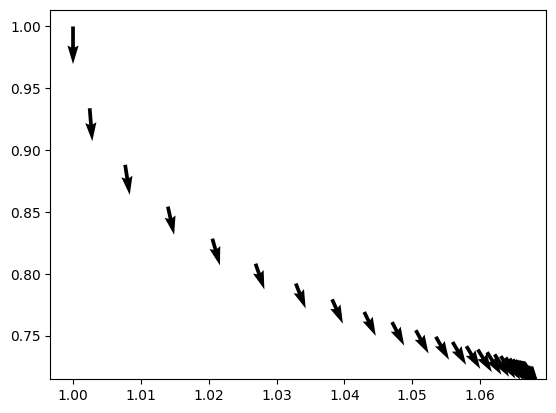

In [12]:
plt.quiver(xs[:,0], xs[:,1], -grads_x[:,0], -grads_x[:,1])

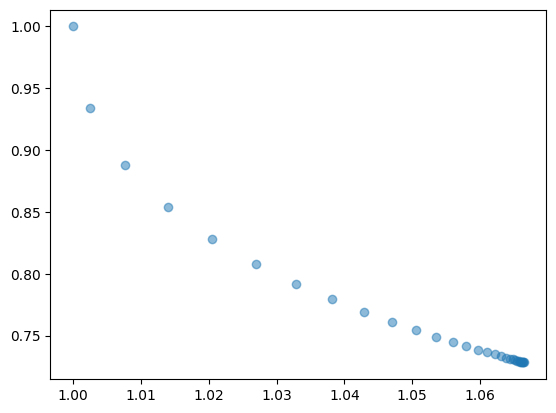

In [13]:
plt.scatter(xs[:, 0], xs[:, 1], alpha=.5)

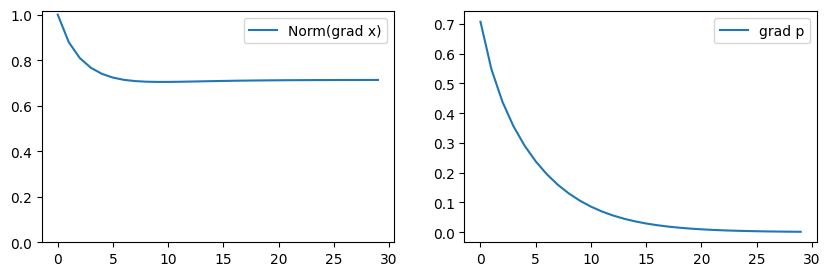

In [14]:
fig1, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axs[0].plot(norm(grads_x, dim=1), label="Norm(grad x)")
axs[0].set_ylim((0, None))
axs[0].legend()
axs[1].plot(grads_p, label="grad p")
axs[1].legend()
plt.show()

# Questions:
* Why $\nabla x$ not reproduce the path followed by optimizing $p$?
* How does the optimization look like if we start closer to the second solution $x_1 \approx 3.5, x_2 = x_1^2$